This notebook reads a bunch of reumes and keywords and tries to classify them in 3 categories of Testing, Development, and Management### Data Pre Processing
We first start off by looking at the data and understanding the structure of the json data in the given input file. We ignore the text and try to find the number of unique annotation categories in the whole database and do some informed pre-processing for string cleaning etc by manually glossing over the contents of the file.


In [13]:
#alll imports needed for the rest of the file
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import csv, json
import re
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
import scipy

In [2]:
ann_store = []
l_set = dict()
val_set = set()
with open('input.json') as f:
    while True:
        line = f.readline()
        if not line:
            break
        json_string = line
        obj = json.loads(json_string)  
        obj = obj['annotation']
        #[(i['label'],len(i['points'])) for i in obj['annotation'']]
        #break
        #k = [(i['label'],len(i['points'])) for i in obj]
        #ann_store.append(k)
        for i in obj:
            for j in i['label']:
                if j in l_set:
                    l_set[j] += 1
                else:
                    l_set[j] = 1
                
            for k in i['points']:
                val_set.add(k['text'])
print('An example annotation:',obj)
print('\n\nUnique Annotation Labels : occurences  - ',l_set)
    



An example annotation: [{'label': ['Skills'], 'points': [{'start': 587, 'end': 668, 'text': 'Splunk, Network Security, Arc sight (2 years), SIEM (2 years), McAfee ESM (1 year)'}]}, {'label': ['College Name'], 'points': [{'start': 512, 'end': 553, 'text': 'Jawaharlal Nehru Technological University '}]}, {'label': ['Degree'], 'points': [{'start': 503, 'end': 510, 'text': 'B- Tech\n'}]}, {'label': ['Designation'], 'points': [{'start': 177, 'end': 192, 'text': 'Security Analyst'}]}, {'label': ['Companies worked at'], 'points': [{'start': 34, 'end': 57, 'text': 'Infosys - Career Contour'}]}, {'label': ['Designation'], 'points': [{'start': 14, 'end': 29, 'text': 'Security Analyst'}]}, {'label': ['Name'], 'points': [{'start': 0, 'end': 12, 'text': 'Pradeep Kumar'}]}]


Unique Annotation Labels : occurences  -  {'Skills': 472, 'College Name': 330, 'Graduation Year': 254, 'Designation': 521, 'Companies worked at': 729, 'Email Address': 252, 'Location': 430, 'Name': 224, 'Degree': 298, 'Years of

Some experiemnts to find the best way to clean strings and remove unrecognized characters.

In [ ]:
'''a = []
stringer = '\n• Programming language: C, C++, Java\n• Oracle PeopleSoft\n• Internet Of Things\n• Machine Learning\n• Database Management System\n• Computer Networks\n• Operating System worked on: Linux, Windows, Mac\n\nNon - Technical Skills\n\n• Honest and Hard-Working\n• Tolerant and Flexible to Different Situations\n• Polite and Calm\n• Team-Player'
import re
for i in stringer.lower().split():
    clean_word = re.sub(r'\W+', '', i)
    if len(clean_word)>0:
        a.append(clean_word)
import re

list(filter(None, re.split('[; ,  \*  \n  \:  \-   •]',stringer.lower())))'''

We now start reading the data in the correct format and collect the annotation labels of these resumes into  list of sentences - word_store.
Since the dataset has 220 CVs, word_store would also have 220 elements(strings), Each representing the corresponding CV

In [4]:


#list(filter(None, re.split('[; ,  \*  \n  \:  \-   •]',stringer.lower())))
word_store = []

with open('input.json') as f:
    while True:
        line_word_list = []
        line = f.readline()
        if not line:
            break
        json_string = line
        obj = json.loads(json_string)  
        obj = obj['annotation']
        for entry in obj:
            for i,label in enumerate(entry['label']):
                if label in ['Skills', 'College Name','Designation', 'Degree' ]:  #Only consider certain labels
                    for i in entry['points'][i]['text'].lower().split(): #format raw string to words
                        clean_word = re.sub('[^a-z A-Z]', '', i) #make sure the words are only alphabets, no nums, no special chars. 
                        if len(clean_word)>0: #make sure the words aren't empty strings
                            line_word_list.append(clean_word)
        word_store.append(line_word_list)
        
    

A quick look at the types of words in the word_store in the next cell. We can see the keywords such as testing, management, engineering etc.

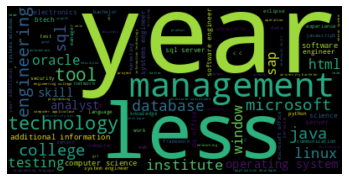

In [12]:

#% matplotlib inline


# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join([ ' '.join(i)  for i in word_store]))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Model Building starts Here. 
We first define some stop words that are common in the language. I did also find some more stop words that can be included that are common to all 3 groups. We then run TF-IDF  to generate TFIDF vectors from these word strings.
The problem to be solved is to assign a score for each of these resumes for the groups of Testing, Development and Management. Since we do not have the Group labels given, this is an unsupervised problem of Clustering. I choose to solve this problem using KMeans simply because of the lack of time. Other Soft Clustering methods can also be explored to solve this problem. 

In [14]:

my_stop_words = text.ENGLISH_STOP_WORDS.union(["year","years",'university','school','college','high','member'])

tfidfvect = TfidfVectorizer(stop_words=my_stop_words)#'english'
X = tfidfvect.fit_transform([ ' '.join(i)  for i in word_store])

In [30]:
num = 3  #Number of clusters
#Documentation and reference for model API and model attrributes: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters = num, init = 'k-means++', max_iter = 100, n_init = 10)
kmeans.fit(X)


KMeans(max_iter=100, n_clusters=3)

In [31]:
terms = tfidfvect.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

The model has been built. I did play with the parameters of 'max_iter' and 'n_init' in the KMeans.fit cell to get a proper distribution of popular words in each of the 3 clusters that would correspond to our labels. As we can see from the popular words, we assign Cluster 0 to development, Cluster 1 to Management and Cluster  to testing,.

In [32]:
for i in range(3):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :5]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: consultant microsoft engineering office sap 
Cluster 1: management executive senior skills good 
Cluster 2: engineer software testing java sql 


In [33]:
lister = []
cluster_names = {2:'Testing',0:'Development',1:'Management'}
for i,dp in enumerate(X):
    row = []
    a,b,c = scipy.special.softmax(-kmeans.transform(dp))[0]
    row = [i+1, cluster_names[kmeans.predict(dp)[0]],  a,b,c ]
    lister.append(row)
df = pd.DataFrame(lister, columns=['Index', 'Group', 'Dev Score' , 'Management Score','Testing score'])
  
# print dataframe.
df
    
    

,Index,Group,Dev Score,Management Score,Testing score
0,1,Testing,0.331472,0.329689,0.338839
1,2,Testing,0.333627,0.324003,0.342370
2,3,Testing,0.331887,0.329820,0.338293
3,4,Testing,0.332570,0.323976,0.343454
4,5,Testing,0.331110,0.327904,0.340986
...,...,...,...,...,...
215,216,Development,0.340975,0.330407,0.328619
216,217,Management,0.337346,0.339604,0.323050
217,218,Development,0.342488,0.332070,0.325443
218,219,Management,0.334775,0.338594,0.326631


The Group score can be calculated using scipy's softmax function since the KMeans model only gives us the distances from the centroids(the .transform function). The group scores aren't very good (Very Close i.e almost equally likely) since the documents are less, and the annotations aren't up to the mark or very relevant. Better models can be constructed by analyzing whole documents and using some sort of Semi-supervised setup (like Autoencoder-Classifier pipeline sort of architecture) or using Fuzzy Clustering Algorithms .